## Blaze Face (2019)

Paper: https://arxiv.org/abs/1907.05047

> We present BlazeFace, a lightweight and well-performing face detector tailored for mobile GPU inference. It
runs at a speed of 200–1000+ FPS on flagship devices.


Notes:
- Fast
- Doesn't use NMS because NMS introduces jitter if you run face recognition on subsequent frames. Uses an averaging approach.


In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

In [2]:


class BlazeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(BlazeBlock, self).__init__()

        self.stride = stride
        self.channel_pad = out_channels - in_channels

        # TFLite uses slightly different padding than PyTorch 
        # on the depthwise conv layer when the stride is 2.
        if stride == 2:
            self.max_pool = nn.MaxPool2d(kernel_size=stride, stride=stride)
            padding = 0
        else:
            padding = (kernel_size - 1) // 2

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding, 
                      groups=in_channels, bias=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=1, stride=1, padding=0, bias=True),
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.stride == 2:
            h = F.pad(x, (0, 2, 0, 2), "constant", 0)
            x = self.max_pool(x)
        else:
            h = x

        if self.channel_pad > 0:
            x = F.pad(x, (0, 0, 0, 0, 0, self.channel_pad), "constant", 0)

        return self.act(self.convs(h) + x)


class BlazeFace(nn.Module):
    """The BlazeFace face detection model from MediaPipe.
    
    The version from MediaPipe is simpler than the one in the paper; 
    it does not use the "double" BlazeBlocks.

    Because we won't be training this model, it doesn't need to have
    batchnorm layers. These have already been "folded" into the conv 
    weights by TFLite.

    The conversion to PyTorch is fairly straightforward, but there are 
    some small differences between TFLite and PyTorch in how they handle
    padding on conv layers with stride 2.

    This version works on batches, while the MediaPipe version can only
    handle a single image at a time.

    Based on code from https://github.com/tkat0/PyTorch_BlazeFace/ and
    https://github.com/google/mediapipe/
    """
    input_size = (128, 128)
    
    def __init__(self):
        super(BlazeFace, self).__init__()

        # These are the settings from the MediaPipe example graph
        # mediapipe/graphs/face_detection/face_detection_mobile_gpu.pbtxt
        self.num_classes = 1
        self.num_anchors = 896
        self.num_coords = 16
        self.score_clipping_thresh = 100.0
        self.x_scale = 128.0
        self.y_scale = 128.0
        self.h_scale = 128.0
        self.w_scale = 128.0
        self.min_score_thresh = 0.75
        self.min_suppression_threshold = 0.3

        self._define_layers()

    def _define_layers(self):
        self.backbone1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding=0, bias=True),
            nn.ReLU(inplace=True),

            BlazeBlock(24, 24),
            BlazeBlock(24, 28),
            BlazeBlock(28, 32, stride=2),
            BlazeBlock(32, 36),
            BlazeBlock(36, 42),
            BlazeBlock(42, 48, stride=2),
            BlazeBlock(48, 56),
            BlazeBlock(56, 64),
            BlazeBlock(64, 72),
            BlazeBlock(72, 80),
            BlazeBlock(80, 88),
        )
        
        self.backbone2 = nn.Sequential(
            BlazeBlock(88, 96, stride=2),
            BlazeBlock(96, 96),
            BlazeBlock(96, 96),
            BlazeBlock(96, 96),
            BlazeBlock(96, 96),
        )

        self.classifier_8 = nn.Conv2d(88, 2, 1, bias=True)
        self.classifier_16 = nn.Conv2d(96, 6, 1, bias=True)

        self.regressor_8 = nn.Conv2d(88, 32, 1, bias=True)
        self.regressor_16 = nn.Conv2d(96, 96, 1, bias=True)
        
    def forward(self, x):
        # TFLite uses slightly different padding on the first conv layer
        # than PyTorch, so do it manually.
        x = F.pad(x, (1, 2, 1, 2), "constant", 0)
        
        b = x.shape[0]      # batch size, needed for reshaping later

        x = self.backbone1(x)           # (b, 88, 16, 16)
        h = self.backbone2(x)           # (b, 96, 8, 8)
        
        # Note: Because PyTorch is NCHW but TFLite is NHWC, we need to
        # permute the output from the conv layers before reshaping it.
        
        c1 = self.classifier_8(x)       # (b, 2, 16, 16)
        c1 = c1.permute(0, 2, 3, 1)     # (b, 16, 16, 2)
        c1 = c1.reshape(b, -1, 1)       # (b, 512, 1)

        c2 = self.classifier_16(h)      # (b, 6, 8, 8)
        c2 = c2.permute(0, 2, 3, 1)     # (b, 8, 8, 6)
        c2 = c2.reshape(b, -1, 1)       # (b, 384, 1)

        c = torch.cat((c1, c2), dim=1)  # (b, 896, 1)

        r1 = self.regressor_8(x)        # (b, 32, 16, 16)
        r1 = r1.permute(0, 2, 3, 1)     # (b, 16, 16, 32)
        r1 = r1.reshape(b, -1, 16)      # (b, 512, 16)

        r2 = self.regressor_16(h)       # (b, 96, 8, 8)
        r2 = r2.permute(0, 2, 3, 1)     # (b, 8, 8, 96)
        r2 = r2.reshape(b, -1, 16)      # (b, 384, 16)

        r = torch.cat((r1, r2), dim=1)  # (b, 896, 16)
        return [r, c]

    def _device(self):
        """Which device (CPU or GPU) is being used by this model?"""
        return self.classifier_8.weight.device
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()        
    
    def load_anchors(self, path):
        self.anchors = torch.tensor(np.load(path), dtype=torch.float32, device=self._device())
        assert(self.anchors.ndimension() == 2)
        assert(self.anchors.shape[0] == self.num_anchors)
        assert(self.anchors.shape[1] == 4)

    def _preprocess(self, x):
        """Converts the image pixels to the range [-1, 1]."""
        return x.float() / 127.5 - 1.0

    def predict_on_image(self, img):
        """Makes a prediction on a single image.

        Arguments:
            img: a NumPy array of shape (H, W, 3) or a PyTorch tensor of
                 shape (3, H, W). The image's height and width should be 
                 128 pixels.

        Returns:
            A tensor with face detections.
        """
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute((2, 0, 1))

        return self.predict_on_batch(img.unsqueeze(0))[0]

    def predict_on_batch(self, x, apply_nms=True):
        """Makes a prediction on a batch of images.

        Arguments:
            x: a NumPy array of shape (b, H, W, 3) or a PyTorch tensor of
               shape (b, 3, H, W). The height and width should be 128 pixels.
            apply_nms: pass False to not apply non-max suppression

        Returns:
            A list containing a tensor of face detections for each image in 
            the batch. If no faces are found for an image, returns a tensor
            of shape (0, 17).

        Each face detection is a PyTorch tensor consisting of 17 numbers:
            - ymin, xmin, ymax, xmax
            - x,y-coordinates for the 6 keypoints
            - confidence score
        """
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).permute((0, 3, 1, 2))

        assert x.shape[1] == 3
        assert x.shape[2] == 128
        assert x.shape[3] == 128

        # 1. Preprocess the images into tensors:
        x = x.to(self._device())
        x = self._preprocess(x)

        # 2. Run the neural network:
        with torch.no_grad():
            out = self.__call__(x)

        # 3. Postprocess the raw predictions:
        detections = self._tensors_to_detections(out[0], out[1], self.anchors)

        # 4. Non-maximum suppression to remove overlapping detections:
        return self.nms(detections) if apply_nms else detections

    def nms(self, detections):
        """Filters out overlapping detections."""
        filtered_detections = []
        for i in range(len(detections)):
            faces = self._weighted_non_max_suppression(detections[i])
            faces = torch.stack(faces) if len(faces) > 0 else torch.zeros((0, 17), device=self._device())
            filtered_detections.append(faces)

        return filtered_detections
    
    def _tensors_to_detections(self, raw_box_tensor, raw_score_tensor, anchors):
        """The output of the neural network is a tensor of shape (b, 896, 16)
        containing the bounding box regressor predictions, as well as a tensor 
        of shape (b, 896, 1) with the classification confidences.

        This function converts these two "raw" tensors into proper detections.
        Returns a list of (num_detections, 17) tensors, one for each image in
        the batch.

        This is based on the source code from:
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.proto
        """
        assert raw_box_tensor.ndimension() == 3
        assert raw_box_tensor.shape[1] == self.num_anchors
        assert raw_box_tensor.shape[2] == self.num_coords

        assert raw_score_tensor.ndimension() == 3
        assert raw_score_tensor.shape[1] == self.num_anchors
        assert raw_score_tensor.shape[2] == self.num_classes

        assert raw_box_tensor.shape[0] == raw_score_tensor.shape[0]
        
        detection_boxes = self._decode_boxes(raw_box_tensor, anchors)
        
        thresh = self.score_clipping_thresh
        raw_score_tensor = raw_score_tensor.clamp(-thresh, thresh)
        detection_scores = raw_score_tensor.sigmoid().squeeze(dim=-1)
        
        # Note: we stripped off the last dimension from the scores tensor
        # because there is only has one class. Now we can simply use a mask
        # to filter out the boxes with too low confidence.
        mask = detection_scores >= self.min_score_thresh

        # Because each image from the batch can have a different number of
        # detections, process them one at a time using a loop.
        output_detections = []
        for i in range(raw_box_tensor.shape[0]):
            boxes = detection_boxes[i, mask[i]]
            scores = detection_scores[i, mask[i]].unsqueeze(dim=-1)
            output_detections.append(torch.cat((boxes, scores), dim=-1))

        return output_detections

    def _decode_boxes(self, raw_boxes, anchors):
        """Converts the predictions into actual coordinates using
        the anchor boxes. Processes the entire batch at once.
        """
        boxes = torch.zeros_like(raw_boxes)

        x_center = raw_boxes[..., 0] / self.x_scale * anchors[:, 2] + anchors[:, 0]
        y_center = raw_boxes[..., 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]

        w = raw_boxes[..., 2] / self.w_scale * anchors[:, 2]
        h = raw_boxes[..., 3] / self.h_scale * anchors[:, 3]

        boxes[..., 0] = y_center - h / 2.  # ymin
        boxes[..., 1] = x_center - w / 2.  # xmin
        boxes[..., 2] = y_center + h / 2.  # ymax
        boxes[..., 3] = x_center + w / 2.  # xmax

        for k in range(6):
            offset = 4 + k*2
            keypoint_x = raw_boxes[..., offset    ] / self.x_scale * anchors[:, 2] + anchors[:, 0]
            keypoint_y = raw_boxes[..., offset + 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]
            boxes[..., offset    ] = keypoint_x
            boxes[..., offset + 1] = keypoint_y

        return boxes

    def _weighted_non_max_suppression(self, detections):
        """The alternative NMS method as mentioned in the BlazeFace paper:

        "We replace the suppression algorithm with a blending strategy that
        estimates the regression parameters of a bounding box as a weighted
        mean between the overlapping predictions."

        The original MediaPipe code assigns the score of the most confident
        detection to the weighted detection, but we take the average score
        of the overlapping detections.

        The input detections should be a Tensor of shape (count, 17).

        Returns a list of PyTorch tensors, one for each detected face.
        
        This is based on the source code from:
        mediapipe/calculators/util/non_max_suppression_calculator.cc
        mediapipe/calculators/util/non_max_suppression_calculator.proto
        """
        if len(detections) == 0: return []

        output_detections = []

        # Sort the detections from highest to lowest score.
        remaining = torch.argsort(detections[:, 16], descending=True)

        while len(remaining) > 0:
            detection = detections[remaining[0]]

            # Compute the overlap between the first box and the other 
            # remaining boxes. (Note that the other_boxes also include
            # the first_box.)
            first_box = detection[:4]
            other_boxes = detections[remaining, :4]
            ious = overlap_similarity(first_box, other_boxes)

            # If two detections don't overlap enough, they are considered
            # to be from different faces.
            mask = ious > self.min_suppression_threshold
            overlapping = remaining[mask]
            remaining = remaining[~mask]

            # Take an average of the coordinates from the overlapping
            # detections, weighted by their confidence scores.
            weighted_detection = detection.clone()
            if len(overlapping) > 1:
                coordinates = detections[overlapping, :16]
                scores = detections[overlapping, 16:17]
                total_score = scores.sum()
                weighted = (coordinates * scores).sum(dim=0) / total_score
                weighted_detection[:16] = weighted
                weighted_detection[16] = total_score / len(overlapping)

            output_detections.append(weighted_detection)

        return output_detections    


# IOU code from https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py

def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def overlap_similarity(box, other_boxes):
    """Computes the IOU between a bounding box and set of other boxes."""
    return jaccard(box.unsqueeze(0), other_boxes).squeeze(0)

In [3]:
def read_frame_as_size(video_path, size=(128, 128)):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    capture.release()
    return frame

def read_frame(video_path):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    capture.release()
    return frame


def read_all_frames(video_path):
    capture = cv2.VideoCapture(str(video_path))
    all_frames = []
    ret = True
    while True:
        ret, frame = capture.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            all_frames.append(frame)
        else:
            break
    
    capture.release()
    return all_frames


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector = BlazeFace().to(device)

detector.load_weights("blazeface.pth")
detector.load_anchors("anchors.npy")

In [5]:
data = Path('../data')

# Two easy faces to ensure that we can get facial recognition working
easy1 = data/'dfdc_train_part_2/abmjszfycr_REAL.mp4'
easy2 = data/'dfdc_train_part_11/aqyvunegbf_REAL.mp4'

In [7]:
# Optionally change the thresholds:
# detector.min_score_thresh = 0.75
# detector.min_suppression_threshold = 0.3

In [8]:
frame1 = read_frame(easy1)
frame2 = read_frame(easy2)

In [11]:
detections1 = detector.predict_on_image(cv2.resize(frame1, (128, 128)))
detections2 = detector.predict_on_image(cv2.resize(frame2, (128, 128)))

In [12]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

Found 1 faces


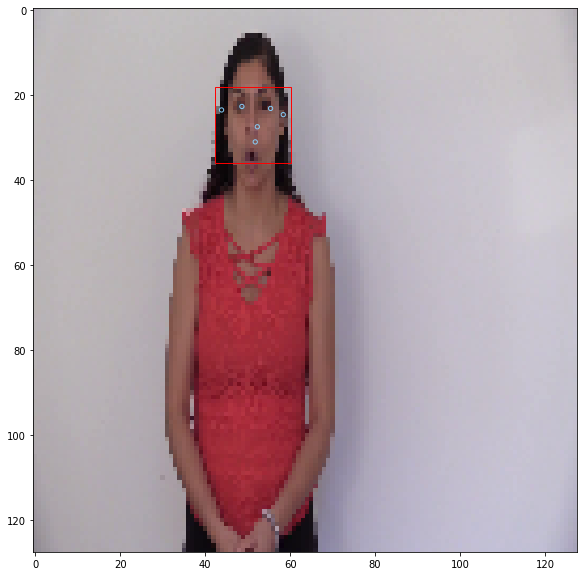

Found 1 faces


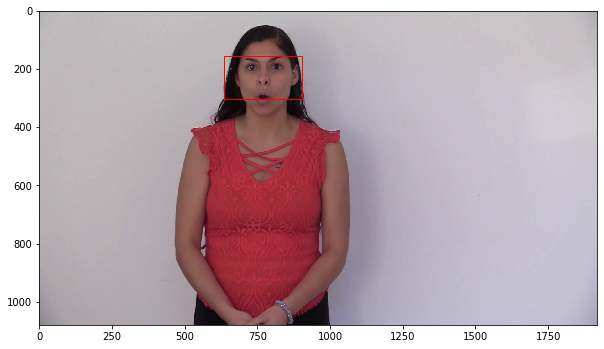

In [13]:
plot_detections(cv2.resize(frame1, (128, 128)), detections1)
plot_detections(frame1, detections1)

Found 1 faces


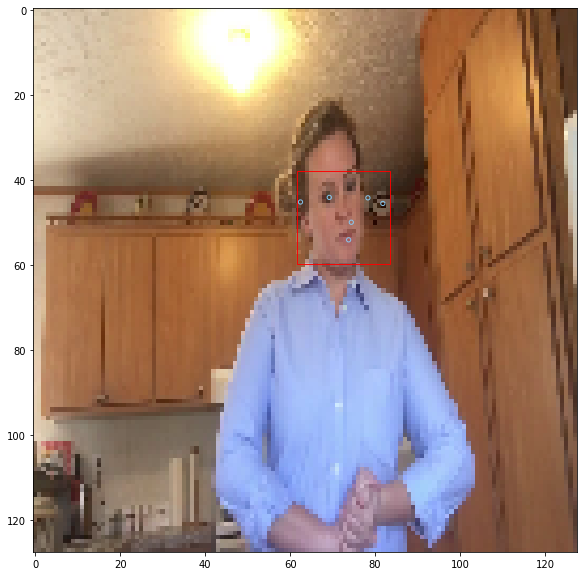

Found 1 faces


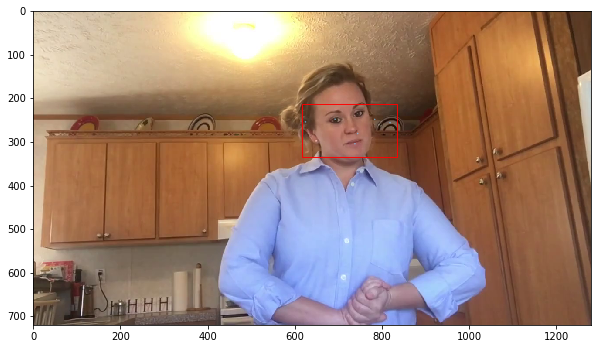

In [14]:
plot_detections(cv2.resize(frame2, (128, 128)), detections2)
plot_detections(frame2, detections2)

The output from our model seems to be a square which is really annoying because we're reshaping our images before inputting them to the model.

## Crop Face

In [15]:
def get_cropped_faces(frame, detections):
    
    faces = []
    
    for detection in detections:
        ymin = max(0, int(detection[0] * frame.shape[0])) # Don't try to crop less than 0
        xmin = max(0, int(detection[1] * frame.shape[1])) # Don't try to crop less than 0
        ymax = min(frame.shape[0], int(detection[2] * frame.shape[0]))
        xmax = min(frame.shape[1], int(detection[3] * frame.shape[1]))
        
        face = frame[ymin:ymax, xmin:xmax]
        
        faces.append(face)
    
    return faces

In [103]:
def display_cropped_faces(frame, detections):
    
    cropped_faces = get_cropped_faces(frame, detections)
    for face in cropped_faces:
        plt.imshow(face)
        plt.show()


In [136]:
def get_cropped_faces_adjusted_for_aspect_ratio(frame, detections):
    """
    BlazeFace requires square inputs which messes up our bounding boxes. 
    We attempt to undo this damage by adjust the bounding boxes according to
    the aspect ratio of the frame
    """
    
    faces = []
    
    for detection in detections:
        
        y_min, x_min, y_max, x_max, *_ = detection
        
        # We need, center height and width
        height_ratio = ((frame.shape[0] / frame.shape[1]) + 1) / 2
        width_ratio = ((frame.shape[1] / frame.shape[0]) + 1) / 2

        center_y = (y_max + y_min) / 2
        center_x = (x_min + x_max) / 2

        width = x_max - x_min
        height = y_max - y_min

        height = (1/height_ratio) * height  # undo the original height change
        width =  (1/width_ratio) * width    # undo the original width change

        # Center is the same, height and width are adjusted by the ratio
        y_min = center_y - (height / 2)
        y_max = center_y + (height / 2)

        x_min = center_x - (width / 2)
        x_max = center_x + (width / 2)
        
        y_min = int(max(0, y_min * frame.shape[0])) # Don't try to crop less than 0
        x_min = int(max(0, x_min * frame.shape[1])) # Don't try to crop less than 0
        y_max = int(min(frame.shape[0], y_max * frame.shape[0]))
        x_max = int(min(frame.shape[1], x_max * frame.shape[1]))
        
        face = frame[y_min:y_max, x_min:x_max]
        
        faces.append(face)
    
    return faces

In [144]:
def display_cropped_faces_fixed(frame, detections):
    
    cropped_faces = get_cropped_faces_adjusted_for_aspect_ratio(frame, detections)
    for face in cropped_faces:
        plt.imshow(face)
        plt.show()
    

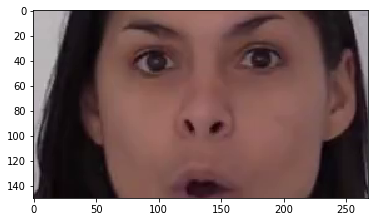

In [146]:
# Original crop from Blazeface is no longer a square once we map it back to the original image
display_cropped_faces(frame1, detections1)

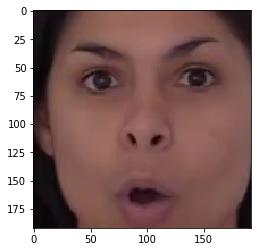

In [149]:
# We can "undo" this by adjusting for aspect ratio
display_cropped_faces_fixed(frame1, detections1)

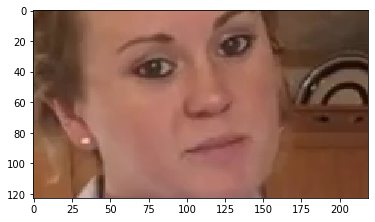

In [147]:
display_cropped_faces(frame2, detections2)

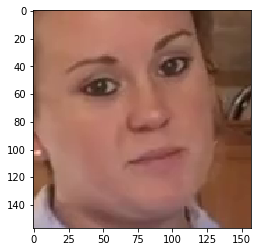

In [148]:
display_cropped_faces_fixed(frame2, detections2)

So this works reasonably well but I'm worried that there are some lingering problems:

When we squish the image to `(128, 128)` we're distorting the faces present in the video, presumably making it harder for BlazeFace to find the right face. This isn't a problem on easy faces but is probably one on harder faces.